# 0. Import self-built src functions to read the data, run regression algos, plot functions
## And import standard libraries

In [1]:
# functions to read data, run regression algos, plotting - please refer to "src" folder
from src.utils import read_data, missing_vals
from src.regression_algorithms import run_reg_pred, algo_map
from src.plot_functions import line_plot_date

# ML and standard libs
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime, timedelta
import calendar
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('Solarize_Light2')

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Util function to display many dataframes horizontally

In [3]:
from IPython.display import display_html, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def display_dfs(dfs, gap=50, justify='center'):
    html = ""
    for title, df in dfs.items():  
        df_html = df._repr_html_()
        cur_html = f'<div> <h3>{title}</h3> {df_html}</div>'
        html +=  cur_html
    html= f"""
    <div style="display:flex; gap:{gap}px; justify-content:{justify};">
        {html}
    </div>
    """
    display_html(html, raw=True)

# 1. Extract Data & Create simple features

In [4]:
dat = read_data()
dat["Forecast_start"] = False

# improving accuracy from ~65% to ~75%
dat["Month"] = pd.DatetimeIndex(dat["Date"]).month
dat["Year"] = pd.DatetimeIndex(dat["Date"]).year

## 1a. Simple analysis

In [5]:
percentiles = [.01, .025, .05, .1, .25, .5, .75, .95, .975, .99, .999]
dfs1 = {'Head': dat.head(5), 'Tail': dat.tail(5)}
dfs2 = {'DTypes': pd.DataFrame(dat.dtypes), 'Describe': dat.describe(percentiles=percentiles).T}
display_dfs(dfs1, justify='flex-start')
display_dfs(dfs2, justify='flex-start')

print("\nMissing values: ")
display(miss := missing_vals(dat))

,Date,Consumption,Forecast_start,Month,Year
0,2015-04-01,357.073,False,4,2015
1,2015-04-02,341.931,False,4,2015
2,2015-04-03,318.777,False,4,2015
3,2015-04-04,312.494,False,4,2015
4,2015-04-05,270.837,False,4,2015
,Date,Consumption,Forecast_start,Month,Year
1822,2020-03-27,237.171,False,3,2020
1823,2020-03-28,229.744,False,3,2020
1824,2020-03-29,297.636,False,3,2020
1825,2020-03-30,323.811,False,3,2020


DTypes 

 
 
 
 
 0 
 
 
 
 
 Date 
 datetime64[ns] 
 
 
 Consumption 
 float64 
 
 
 Forecast_start 
 bool 
 
 
 Month 
 int64 
 
 
 Year 
 int64 
 
 
 
 Describe 

 
 
 
 
 count 
 mean 
 std 
 min 
 1% 
 2.5% 
 5% 
 10% 
 25% 
 50% 
 75% 
 95% 
 97.5% 
 99% 
 99.9% 
 max 
 
 
 
 
 Consumption 
 1827.0 
 257.885096 
 100.993368 
 82.675 
 109.32474 
 118.3223 
 129.2541 
 141.7106 
 174.6725 
 242.719 
 327.841 
 442.6629 
 475.45865 
 523.17992 
 574.534678 
 589.269 
 
 
 Month 
 1827.0 
 6.521073 
 3.450157 
 1.000 
 1.00000 
 1.0000 
 1.0000 
 2.0000 
 4.0000 
 7.000 
 10.000 
 12.0000 
 12.00000 
 12.00000 
 12.000000 
 12.000 
 
 
 Year 
 1827.0 
 2017.247400 
 1.479723 
 2015.000 
 2015.00000 
 2015.0000 
 2015.0000 
 2015.0000 
 2016.0000 
 2017.000 
 2018.000 
 2019.0000 
 2020.00000 
 2020.00000 
 2020.000000 
 2020.000


Missing values: 


,Missing Values,% of Total Values


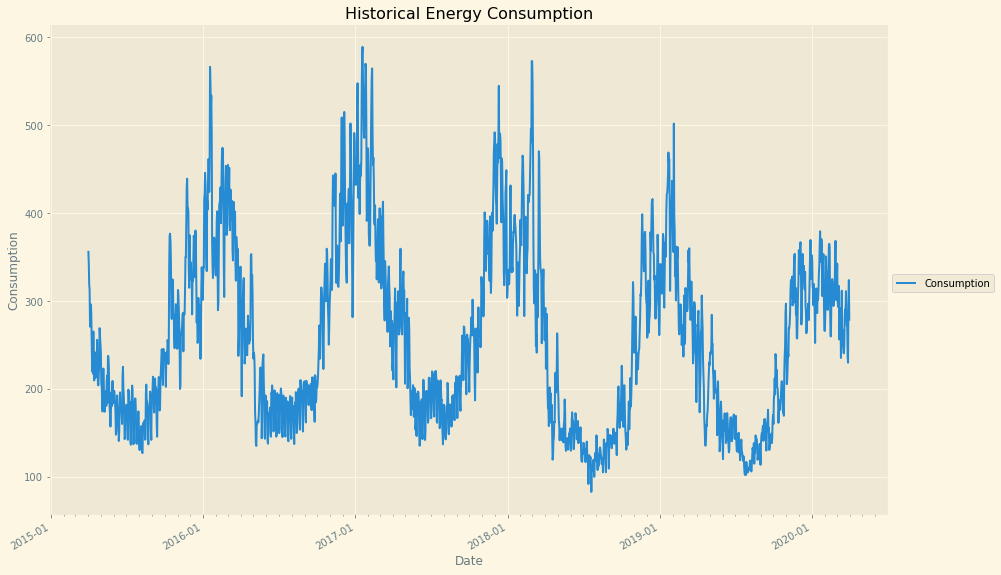

In [6]:
_ = line_plot_date(dat.copy(), "Date", ["Consumption"], "Historical Energy Consumption", ("Date", "Consumption"), None, fig_size=(15, 10))

###  We can observe seasonal / cyclical patterns where in winter (Jan, Feb, Nov, Dec, March) we see the highest mean prices
###  In summer and spring we observe the lowest mean prices (August, July, June, September, May)

In [7]:
dat[["Year"]].value_counts()  # confirm there are 365 days worth of data in a year

Year
2016    366
2017    365
2018    365
2019    365
2015    275
2020     91
dtype: int64

In [8]:
windows = [1, 7, 30, 90, 180, 270, 365]

In [9]:
# Period differences
for i in windows:
    dat[f"Consumption_{i}D_Delta"] = dat["Consumption"].diff(periods=i)
dat

,Date,Consumption,Forecast_start,Month,Year,Consumption_1D_Delta,Consumption_7D_Delta,Consumption_30D_Delta,Consumption_90D_Delta,Consumption_180D_Delta,Consumption_270D_Delta,Consumption_365D_Delta
0,2015-04-01,357.073,False,4,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-04-02,341.931,False,4,2015,-15.142,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-04-03,318.777,False,4,2015,-23.154,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-04-04,312.494,False,4,2015,-6.283,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-04-05,270.837,False,4,2015,-41.657,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2020-03-27,237.171,False,3,2020,-34.494,-45.234,-110.809,-117.924,74.216,79.797,-35.892
1823,2020-03-28,229.744,False,3,2020,-7.427,-60.614,-138.716,-139.707,59.537,62.259,6.011
1824,2020-03-29,297.636,False,3,2020,67.892,8.363,-30.221,-50.648,137.514,128.430,112.647
1825,2020-03-30,323.811,False,3,2020,26.175,12.548,23.012,-1.280,136.037,185.962,100.876


In [10]:
def moving_average(x_dat, window):
    return np.convolve(x_dat, np.ones(window), 'valid') / window

In [11]:
# Moving averages
for win in windows:
    pref = np.empty(win - 1)
    pref[:] = np.nan
    dat[f"ma_{win}"] = np.concatenate([pref, moving_average(dat["Consumption"], win)])
dat

,Date,Consumption,Forecast_start,Month,Year,Consumption_1D_Delta,Consumption_7D_Delta,Consumption_30D_Delta,Consumption_90D_Delta,Consumption_180D_Delta,Consumption_270D_Delta,Consumption_365D_Delta,ma_1,ma_7,ma_30,ma_90,ma_180,ma_270,ma_365
0,2015-04-01,357.073,False,4,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,357.073,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-04-02,341.931,False,4,2015,-15.142,NaN,NaN,NaN,NaN,NaN,NaN,341.931,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-04-03,318.777,False,4,2015,-23.154,NaN,NaN,NaN,NaN,NaN,NaN,318.777,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-04-04,312.494,False,4,2015,-6.283,NaN,NaN,NaN,NaN,NaN,NaN,312.494,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-04-05,270.837,False,4,2015,-41.657,NaN,NaN,NaN,NaN,NaN,NaN,270.837,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2020-03-27,237.171,False,3,2020,-34.494,-45.234,-110.809,-117.924,74.216,79.797,-35.892,237.171,279.939714,285.624367,307.978989,287.024772,235.699300,223.639140
1823,2020-03-28,229.744,False,3,2020,-7.427,-60.614,-138.716,-139.707,59.537,62.259,6.011,229.744,271.280571,281.000500,306.426689,287.355533,235.929889,223.655608
1824,2020-03-29,297.636,False,3,2020,67.892,8.363,-30.221,-50.648,137.514,128.430,112.647,297.636,272.475286,279.993133,305.863933,288.119500,236.405556,223.964230
1825,2020-03-30,323.811,False,3,2020,26.175,12.548,23.012,-1.280,136.037,185.962,100.876,323.811,274.267857,280.760200,305.849711,288.875261,237.094304,224.240603


In [12]:
np.empty(2)

array([1.11091928e-311, 0.00000000e+000])

## 1b. We select Month, Year, Periodic value delta differences for various windows, Moving Averages for various windows
### With consumption by itself --> Accuracy = 65%
### Additionally with consumption + Month, Year --> Accuracy = 71%
### Additionally With Differences --> Accuracy = 85%
### Additionally With Moving Averages --> Accuracy = 92%

In [13]:
features = ["Consumption", "Month", "Year"] + [f"Consumption_{x}D_Delta" for x in windows] + [f"ma_{x}" for x in windows]

# 2. Run all algos in src.regression_algorithms.algo_map for a number of iterations

In [14]:
preds = {"algo": [], "preds": [], "accuracy": [], "mse": [], "iter": []}
NUM_DAYS = 365
NUM_ITER = 10   

start_time = datetime.now()
for i in range(NUM_ITER):
    for algo_name, algo in algo_map.items():
        if 'vote_' not in algo_name:  # ignoring voting algos
            res = run_reg_pred(dat[features], "Consumption", NUM_DAYS, algo_name=algo_name)
            preds["preds"].append(res["preds"])
            preds["accuracy"].append(res["accuracy"])
            preds["mse"].append(res["mse"])
            preds["algo"].append(algo_name)
            preds["iter"].append(i)
end_time = datetime.now()

preds_df = pd.DataFrame(preds)
print(f"{NUM_ITER} iterations of running {len(algo_map.keys())} algos took {end_time - start_time} seconds")

10 iterations of running 27 algos took 0:00:43.614705 seconds


In [15]:
preds_df = preds_df.sort_values(by=["accuracy"], ascending=False)
preds_df.reset_index(inplace=True, drop=True)

## 2a. Top 20 model training and prediction runs. Accuracy refers to the accuracy of the TEST split dataset

In [16]:
preds_df.head(20)

,algo,preds,accuracy,mse,iter
0,hist_grad_boost_0,"[274.8568602455603, 268.77778801122065, 269.40...",0.923819,754.735426,6
1,hist_grad_boost_0,"[277.2466547638015, 286.527444107373, 283.1435...",0.920911,749.045619,0
2,hist_grad_boost_0,"[279.44569674325, 274.12825095980975, 284.7174...",0.918033,736.328216,9
3,hist_grad_boost_0,"[294.21992690406574, 288.2587328641187, 292.30...",0.910078,825.862891,8
4,hist_grad_boost_0,"[284.0912824573319, 281.82408857612506, 279.64...",0.909082,912.799579,7
5,grad_boost_1,"[279.4186694127743, 281.53141591009, 281.06576...",0.904737,944.588454,2
6,hist_grad_boost_0,"[271.42172768557197, 279.6685290499579, 279.80...",0.902100,754.156199,3
7,hist_grad_boost_0,"[283.22442192470726, 281.1044642909607, 285.17...",0.899684,854.267424,4
8,hist_grad_boost_0,"[287.4117964384581, 273.05736555660405, 276.72...",0.899047,973.256752,5
9,grad_boost_0,"[281.21804625294016, 293.40240987568484, 289.1...",0.895487,1024.530856,7


## 2b. Aggregate prediction runs showing best results

In [17]:
preds_df_gp = preds_df.groupby(by=["algo"]).agg({
    "accuracy": ["min", "max", "mean"],
    "mse": ["min", "max", "mean"]})
preds_df_gp = preds_df_gp.sort_values(by=[("accuracy", "mean")], ascending=False)
preds_df_gp

accuracy                              mse  \
                               min       max      mean          min   
algo                                                                  
hist_grad_boost_0         0.892063  0.923819  0.906964   736.328216   
grad_boost_0              0.871517  0.895487  0.881038   993.791120   
grad_boost_1              0.837039  0.904737  0.879620   922.731449   
svr_poly_coef             0.766684  0.815027  0.790300  1483.731770   
ridge                     0.766743  0.827169  0.788668  1574.857330   
svr_poly_auto_coef        0.766001  0.808768  0.784979  1673.972303   
svr_poly_scale_coef       0.753087  0.816597  0.783643  1606.865106   
lasso                     0.753135  0.823896  0.781267  1660.248839   
lin_reg                   0.713246  0.792211  0.759770  1664.226501   
hist_grad_boost_0_LR      0.699420  0.764472  0.744611  1813.486436   
elasticnet                0.712264  0.770075  0.735157  2155.665222   
randomforest_1            0.703138  0.757547  0.729872  2103.675537   
randomforest_0            0.663879  0.763005  0.719497  2053.514134   
grad_boost_0_LR           0.674361  0.699590  0.683190  2375.980705   
svr_poly_auto_lerr_coef   0.619606  0.684611  0.647958  2759.199069   
svr_poly_scale_lerr_coef  0.605195  0.697992  0.646492  2262.182994   
svr_poly_lerr_coef        0.588123  0.667078  0.626481  2727.209701   
svr_linear                0.569928  0.640393  0.619350  3020.469673   
svr_poly_auto             0.480147  0.630817  0.576435  3129.728669   
svr_poly_scale            0.532871  0.587679  0.557686  3355.100256   
svr_poly                  0.488407  0.597002  0.542420  3252.523926   
svr_poly_auto_lerr        0.207307  0.270382  0.241324  5739.280450   
svr_poly_lerr             0.169541  0.239303  0.212500  6485.710108   
svr_poly_scale_lerr       0.148519  0.270940  0.208176  6438.120314   

                                                    
                                  max         mean  
algo                                                
hist_grad_boost_0         1039.654847   861.579661  
grad_boost_0              1155.240986  1073.498489  
grad_boost_1              1425.912977  1063.787423  
svr_poly_coef             2435.087861  1936.615041  
ridge                     2138.583891  1875.933150  
svr_poly_auto_coef        2427.930728  2025.046458  
svr_poly_scale_coef       2394.419178  1987.408660  
lasso                     2607.932900  2045.206271  
lin_reg                   2603.059982  2158.068462  
hist_grad_boost_0_LR      3114.959160  2295.881470  
elasticnet                2998.451938  2498.661389  
randomforest_1            2850.998255  2449.966891  
randomforest_0            3276.291666  2531.140453  
grad_boost_0_LR           3076.428755  2866.347049  
svr_poly_auto_lerr_coef   3719.498795  3235.561512  
svr_poly_scale_lerr_coef  3615.339743  3144.803039  
svr_poly_lerr_coef        4006.472029  3398.129277  
svr_linear                4233.988511  3453.753028  
svr_poly_auto             5205.380274  3842.073020  
svr_poly_scale            4204.400614  3957.022247  
svr_poly                  5049.398868  4102.900001  
svr_poly_auto_lerr        7585.315058  6464.548096  
svr_poly_lerr             7982.088439  7098.855423  
svr_poly_scale_lerr       8776.101138  7308.664640

## 2c. Get best prediction based on TEST accuracy

In [18]:
best_pred = preds_df.iloc[0]
best_pred

algo                                        hist_grad_boost_0
preds       [274.8568602455603, 268.77778801122065, 269.40...
accuracy                                             0.923819
mse                                                754.735426
iter                                                        6
Name: 0, dtype: object

In [19]:
best_preds = best_pred["preds"]

In [20]:
last_date = dat.iloc[-1]["Date"]
last_date

Timestamp('2020-03-31 00:00:00')

In [21]:
forecast_dates = [last_date + timedelta(days=x + 1) for x in range(NUM_DAYS)]
assert len(best_preds) == len(forecast_dates)
forecast = {
    "Date": forecast_dates, 
    "Consumption": best_preds
}
forecast_df = pd.DataFrame(forecast)
forecast_df["Forecast_start"] = False
forecast_df.iloc[0, 2] = True  # set first row Forecast_start to True
forecast_df

,Date,Consumption,Forecast_start
0,2020-04-01,274.856860,True
1,2020-04-02,268.777788,False
2,2020-04-03,269.403891,False
3,2020-04-04,268.019215,False
4,2020-04-05,265.939688,False
...,...,...,...
360,2021-03-27,279.042104,False
361,2021-03-28,300.582727,False
362,2021-03-29,272.164755,False
363,2021-03-30,272.852608,False


In [22]:
forecast_df[["Date", "Consumption"]].to_csv(r"data\output\forecast.csv")

In [23]:
full_df = pd.concat([dat, forecast_df], axis=0)
full_df

,Date,Consumption,Forecast_start,Month,Year,Consumption_1D_Delta,Consumption_7D_Delta,Consumption_30D_Delta,Consumption_90D_Delta,Consumption_180D_Delta,Consumption_270D_Delta,Consumption_365D_Delta,ma_1,ma_7,ma_30,ma_90,ma_180,ma_270,ma_365
0,2015-04-01,357.073000,False,4.0,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,357.073,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-04-02,341.931000,False,4.0,2015.0,-15.142,NaN,NaN,NaN,NaN,NaN,NaN,341.931,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-04-03,318.777000,False,4.0,2015.0,-23.154,NaN,NaN,NaN,NaN,NaN,NaN,318.777,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-04-04,312.494000,False,4.0,2015.0,-6.283,NaN,NaN,NaN,NaN,NaN,NaN,312.494,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-04-05,270.837000,False,4.0,2015.0,-41.657,NaN,NaN,NaN,NaN,NaN,NaN,270.837,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2021-03-27,279.042104,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
361,2021-03-28,300.582727,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,2021-03-29,272.164755,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,2021-03-30,272.852608,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2d. The red circle dot indicates the starting point of the forecast values
## i.e. all values to the right of the red dot are the forecasted predicted values

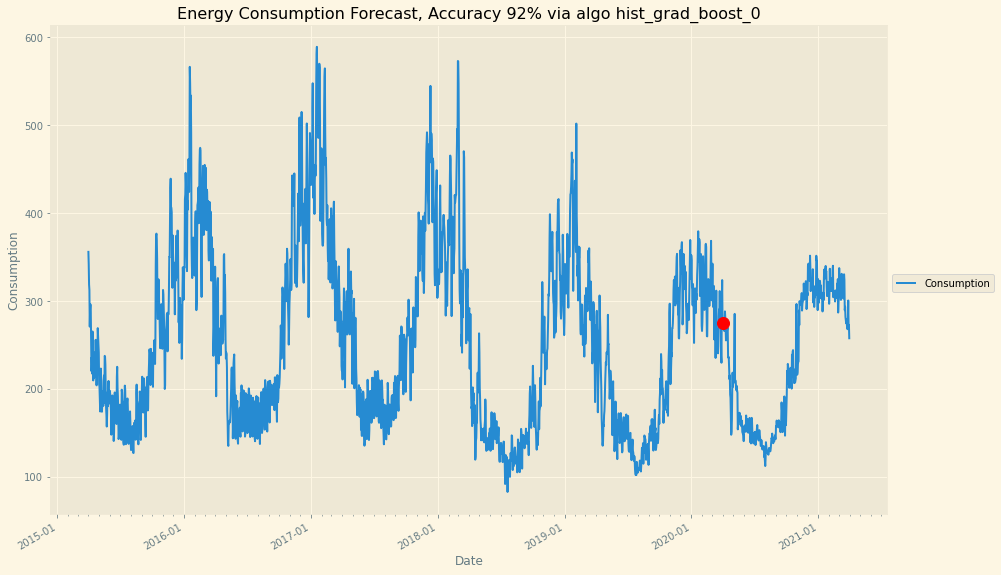

In [24]:
line_plot_date(full_df.copy(), "Date", ["Consumption"], 
               f"Energy Consumption Forecast, Accuracy {round(best_pred['accuracy'] * 100)}% via algo {best_pred['algo']}", 
               ("Date", "Consumption"), r"data\output\forecast.pdf",
               markers={"Forecast_start": ("Consumption", "ro")},
               fig_size=(15, 10))